In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import preprocess_input


## Inisialisasi Awal

In [11]:
class_names = ['BIO','Cardboard','Electronic','Glass','Metal','Paper','Plastic','Trash']
nb_classes = len(class_names)
image_size = (150,150)

## Fungsi Feature

In [12]:
def color_histogram(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist_hue = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_saturation = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_value = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])
    hist_hue /= np.sum(hist_hue)
    hist_saturation /= np.sum(hist_saturation)
    hist_value /= np.sum(hist_value)
    features = np.concatenate((hist_hue, hist_saturation, hist_value), axis=None)
    return features

def shape_descriptor(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Pengecekan apakah ada kontur yang ditemukan
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        aspect_ratio = w / h
        features = np.array([aspect_ratio])
    else:
        features = np.array([0])

    return features

## Load Dataset

In [13]:
def load_data():

    datasets = ['data']
    images = []
    features = []
    labels = []

    # iterate through training and test sets
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['BIO']: label = 0
            if folder in ['Cardboard']: label = 1
            elif folder in ['Electronic']: label = 2
            elif folder in ['Glass']: label = 3
            elif folder in ['Metal']: label = 4
            elif folder in ['Paper']: label = 5
            elif folder in ['Plastic']: label = 6
            elif folder in ['Trash']: label = 7

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the| img
                image = cv2.imread(img_path)
                color_features = color_histogram(image)
                shape_features = shape_descriptor(image)
                combined_features = np.concatenate((color_features, shape_features), axis=None)

                # Label dapat diekstrak dari nama direktori atau nama file
                features.append(combined_features)
                labels.append(label)

    features = np.array(features, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return features, labels

In [14]:
features, labels = load_data()

  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:02<00:00, 209.69it/s]


## Pembagian Dataset

In [21]:
features, labels = shuffle(features, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(features, labels, train_size = 0.8,)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [22]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

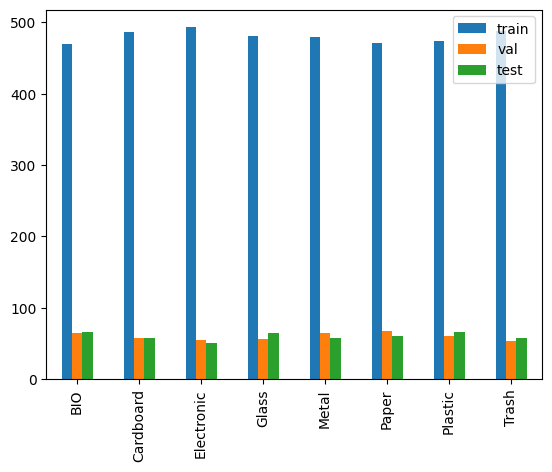

In [23]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

## Implementasi Model Klasik ML

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import ttest_ind
svm_model = SVC(decision_function_shape='ovo')
history = svm_model.fit(train_images, train_labels)

# Make predictions
y_pred = svm_model.predict(test_images)
acc_train = np.mean(train_labels == svm_model.predict(train_images))
acc_test = np.mean(test_labels == y_pred)

# t test
t, p = ttest_ind(train_labels, y_pred)

# Evaluate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy)
print("Accuracy on training:", acc_train)
print("Accuracy on test:", acc_test)
print('p-value: ', p)

Accuracy: 0.39791666666666664
Accuracy on training: 0.45011721802552745
Accuracy on test: 0.39791666666666664
p-value:  0.10130911560491615


## Evaluasi Hasil

In [25]:
print(classification_report(
    test_labels, 
    y_pred, 
    target_names = ['BIO (Class 0)', 'Cardboard (Class 1)', 'Electronic (Class 2)', 'Glass (Class 3)', 'Metal (Class 4)', 'Paper (Class 5)', 'Plastic (Class 6)', 'Trash (Class 7)']))

                      precision    recall  f1-score   support

       BIO (Class 0)       0.54      0.45      0.49        66
 Cardboard (Class 1)       0.58      0.60      0.59        57
Electronic (Class 2)       0.29      0.65      0.40        51
     Glass (Class 3)       0.33      0.22      0.26        64
     Metal (Class 4)       0.33      0.11      0.16        57
     Paper (Class 5)       0.43      0.66      0.52        61
   Plastic (Class 6)       0.41      0.30      0.35        66
     Trash (Class 7)       0.28      0.24      0.26        58

            accuracy                           0.40       480
           macro avg       0.40      0.40      0.38       480
        weighted avg       0.40      0.40      0.38       480



In [27]:
cm = confusion_matrix(test_labels, y_pred)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3', '4', '5', '6', '7'], columns = [['0', '1', '2', '3', '4', '5', '6', '7']])
cm

,0,1,2,3,4,5,6,7
0,30,2,26,0,0,4,0,4
1,5,34,1,1,1,4,5,6
2,4,1,33,0,3,6,0,4
3,1,7,9,14,2,9,18,4
4,8,3,13,5,6,11,6,5
5,1,1,6,9,2,40,0,2
6,1,3,7,10,3,11,20,11
7,6,8,17,4,1,8,0,14


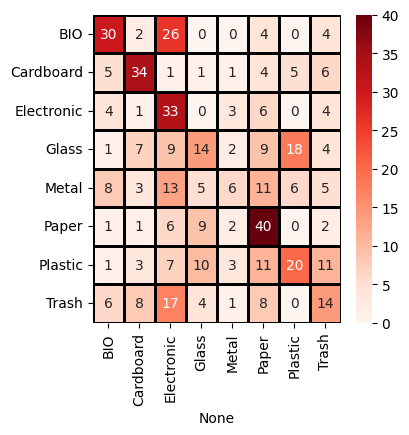

In [28]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (4,4))
    sns.heatmap(
        cm, 
        cmap = 'Reds', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)